# 过拟合、欠拟合及其解决方案
1. 过拟合、欠拟合的概念
2. 权重衰减
3. 丢弃法

# 模型选择、过拟合和欠拟合

## 训练误差和泛化误差
在解释上述现象之前，我们需要区分训练误差（training error）和泛化误差（generalization error）。通俗来讲，前者指模型在训练数据集上表现出的误差，后者指模型在任意一个测试数据样本上表现出的误差的期望，并常常通过测试数据集上的误差来近似。计算训练误差和泛化误差可以使用之前介绍过的损失函数，例如线性回归用到的平方损失函数和softmax回归用到的交叉熵损失函数。

机器学习模型应关注降低泛化误差。

## 模型选择
### 验证数据集
从严格意义上讲，测试集只能在所有超参数和模型参数选定后使用一次。不可以使用测试数据选择模型，如调参。由于无法从训练误差估计泛化误差，因此也不应只依赖训练数据选择模型。鉴于此，我们可以预留一部分在训练数据集和测试数据集以外的数据来进行模型选择。这部分数据被称为验证数据集，简称验证集（validation set）。例如，我们可以从给定的训练集中随机选取一小部分作为验证集，而将剩余部分作为真正的训练集。

### K折交叉验证  
由于验证数据集不参与模型训练，当训练数据不够用时，预留大量的验证数据显得太奢侈。一种改善的方法是K折交叉验证（K-fold cross-validation）。在K折交叉验证中，我们把原始训练数据集分割成K个不重合的子数据集，然后我们做K次模型训练和验证。每一次，我们使用一个子数据集验证模型，并使用其他K-1个子数据集来训练模型。在这K次训练和验证中，每次用来验证模型的子数据集都不同。最后，我们对这K次训练误差和验证误差分别求平均。
## 过拟合和欠拟合
接下来，我们将探究模型训练中经常出现的两类典型问题：
- 一类是模型无法得到较低的训练误差，我们将这一现象称作欠拟合（underfitting）；
- 另一类是模型的训练误差远小于它在测试数据集上的误差，我们称该现象为过拟合（overfitting）。
在实践中，我们要尽可能同时应对欠拟合和过拟合。虽然有很多因素可能导致这两种拟合问题，在这里我们重点讨论两个因素：模型复杂度和训练数据集大小。

### 模型复杂度
为了解释模型复杂度，我们以多项式函数拟合为例。给定一个由标量数据特征$x$和对应的标量标签$y$组成的训练数据集，多项式函数拟合的目标是找一个$K$阶多项式函数


$$
 \hat{y} = b + \sum_{k=1}^K x^k w_k 
$$


来近似 $y$。在上式中，$w_k$是模型的权重参数，$b$是偏差参数。与线性回归相同，多项式函数拟合也使用平方损失函数。特别地，一阶多项式函数拟合又叫线性函数拟合。

给定训练数据集，模型复杂度和误差之间的关系：

![Image Name](https://cdn.kesci.com/upload/image/q5jc27wxoj.png?imageView2/0/w/960/h/960)

### 训练数据集大小
影响欠拟合和过拟合的另一个重要因素是训练数据集的大小。一般来说，如果训练数据集中样本数过少，特别是比模型参数数量（按元素计）更少时，过拟合更容易发生。此外，泛化误差不会随训练数据集里样本数量增加而增大。因此，在计算资源允许的范围之内，我们通常希望训练数据集大一些，特别是在模型复杂度较高时，例如层数较多的深度学习模型。

# 多项式函数拟合实验

In [26]:
%matplotlib inline
import torch
import numpy as np
import sys
sys.path.append("../")
import d2lzh1981 as d2l
print(torch.__version__)

1.1.0


## 初始化模型参数

In [27]:
n_train, n_test, true_w, true_b = 100, 100, [1.2, -3.4, 5.6], 5
features = torch.randn((n_train + n_test, 1))
poly_features = torch.cat((features, torch.pow(features, 2), torch.pow(features, 3)), 1) 
labels = (true_w[0] * poly_features[:, 0] + true_w[1] * poly_features[:, 1]
          + true_w[2] * poly_features[:, 2] + true_b)
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)

In [28]:
features[:2], poly_features[:2], labels[:2]

(tensor([[ 1.0837],
         [-0.3000]]), tensor([[ 1.0837,  1.1745,  1.2729],
         [-0.3000,  0.0900, -0.0270]]), tensor([9.4364, 4.1818]))

## 定义、训练和测试模型

In [29]:
#定义作图函数，确定训练误差和泛化误差之间的关系
def semilogy(x_vals, y_vals, x_label, y_label, 
             x2_vals=None, y2_vals=None, legend=None, figsize=(3.5,2.5)):
    d2l.plt.xlabel(x_label)
    d2l.plt.ylabel(y_label)
    d2l.plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        d2l.plt.semilogy(x2_vals, y2_vals, linestyle=':')
        d2l.plt.legend(legend)

In [30]:
num_epochs,loss = 100, torch.nn.MSELoss()

#尝试使用不同 复杂度模型来训练数据
def fit_and_plot(train_features, test_features, train_labels, test_labels):
    #初始化网络模型
    net = torch.nn.Linear(train_features.shape[-1], 1)
    # 通过Linear文档可知，pytorch已经将参数初始化了，所以我们这里就不手动初始化了
    
    #设置批量大小
    batch_size = min(10, train_labels.shape[0])
    dataset = torch.utils.data.TensorDataset(train_features, train_labels) #设置数据集
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True) #设置获取数据方式
    
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
    train_ls, test_ls = [],[]
    for _ in range(num_epochs):
        for X,y in train_iter:
            l = loss(net(X), y.view(-1,1))
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        
        train_labels = train_labels.view(-1,1)
        test_labels  = test_labels.view(-1,1)
        train_ls.append(loss(net(train_features),train_labels).item())
        test_ls.append(loss(net(test_features),test_labels).item())
    print(f'final epoch: train loss {train_ls[-1]}, test loss {test_ls[-1]}')
    semilogy(range(1,num_epochs+1), train_ls, 'epochs', 'loss',
             range(1,num_epochs+1), test_ls, ['train','test'])
    print(f'weight:{net.weight.data}',
          f'\nbias:{net.bias.data}')

## 三阶多项式函数拟合（正常

final epoch: train loss 0.00012219751079101115, test loss 0.00016125068941619247
weight:tensor([[ 1.2123, -3.3975,  5.5972]]) 
bias:tensor([4.9992])


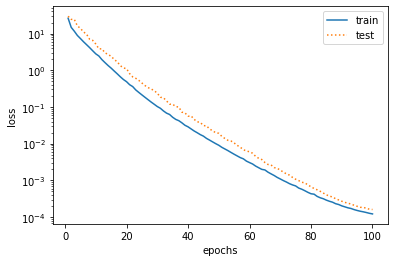

In [31]:
fit_and_plot(poly_features[:n_train, :], poly_features[n_train:, :], labels[:n_train], labels[n_train:])

## 线性函数拟合

final epoch: train loss 86.92064666748047, test loss 172.1492156982422
weight:tensor([[15.8164]]) 
bias:tensor([3.7561])


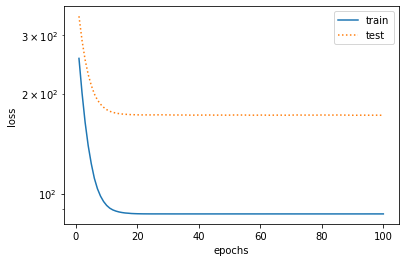

In [32]:
fit_and_plot(features[:n_train, :], features[n_train:, :], labels[:n_train], labels[n_train:])

## 训练样本不足（过拟合）

final epoch: train loss 0.613433837890625, test loss 231.05352783203125
weight:tensor([[1.4084, 1.8184, 1.9854]]) 
bias:tensor([3.3967])


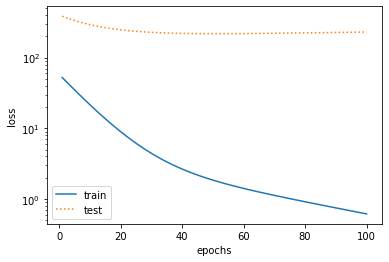

In [33]:
fit_and_plot(poly_features[0:2, :], poly_features[n_train:, :], labels[0:2], labels[n_train:])